# Combining ARIMA with Decomposition

We've already gone through the process of a simple ARIMA model. In this exercise we're going to build on that slightly by using a combination of an ARIMA model with the `seasonal decompose` tool you saw in the lecture. There are models we can use __specifically__ for dealing with seasonality, but we're going to go step by step here and manually pull apart this time series so we fully understand it and some of the issues we can have when working with TS data.

For this challenge we're going to be working with the daily CO2 ppm measurements, specifically, the daily CO2 measurements from the Mauna Loa Observatory 🌋

They have been taken since since 1958, and are a cornerstone of climate science. Perched at over 3,000 meters in Hawaii, the observatory is well-positioned to monitor global atmospheric carbon levels, largely free from local emissions. While the record is robust, __it does contain gaps due to occasional instrument issues or extreme weather__, which researchers must account for in their analyses to maintain the integrity of this critical dataset.  We'll be using a portion of data that has been taken __almost__ daily since 1974 - we will address the gaps in the data throughout the course of the notebook!

If you're curious about the climate work done by the lab, you can read more about it here: https://gml.noaa.gov/ccgg/about/co2_measurements.html

## Loading and exploring the data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/05-Machine-Learning/09-Time-Series/co2_daily_mlo.csv")

In [3]:
df

,year,month,day,CO2 molfrac (ppm)
0,1974,5,17,333.38
1,1974,5,18,333.11
2,1974,5,19,333.46
3,1974,5,20,333.64
4,1974,5,21,333.50
...,...,...,...,...
15191,2023,10,19,419.44
15192,2023,10,20,419.53
15193,2023,10,21,418.90
15194,2023,10,23,419.09


We can see the data isn't formatted very nicely for us to work with, so let's solve that step first by using `pd.to_datetime()` (you can use the function on multiple columns at once 👀). Check the [docs](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html) to find out more.

Once you've formatted it correctly, set it as your index.

In [4]:
# Convert year, month, and day to datetime and set as index
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df.set_index('date', inplace=True)

# Drop the original columns
df.drop(columns=['year', 'month', 'day'], inplace=True)


Plot out your CO2 values and discuss with your partner what you see. Does it look like you have any gaps in your data? Are you __sure__? Check the top 50 values of your DataFrame

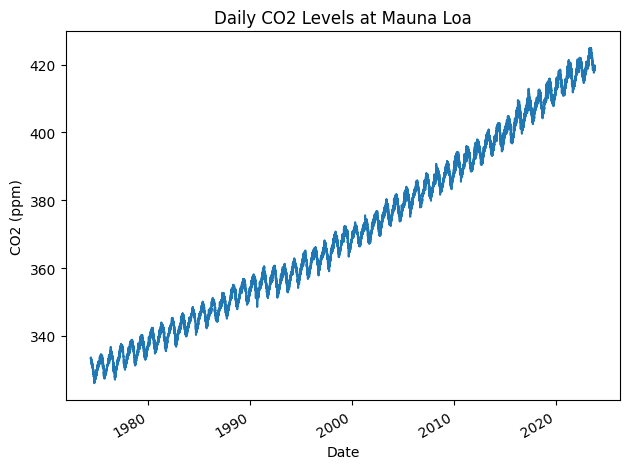

,CO2 molfrac (ppm)
date,
1974-05-17,333.38
1974-05-18,333.11
1974-05-19,333.46
1974-05-20,333.64
1974-05-21,333.50
1974-05-22,333.21
1974-05-23,333.05
1974-05-26,333.32
1974-05-27,332.79


In [5]:
import matplotlib.pyplot as plt

# Plot the CO2 values
df.plot(y='CO2 molfrac (ppm)', legend=False, title='Daily CO2 Levels at Mauna Loa')
plt.ylabel('CO2 (ppm)')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

# Check the top 50 values of the DataFrame
df.head(50)


We're missing some dates 😱 Even though we don't have any obvious `NaN` values, there are missing dates from our index. This is something you need to be __really__ careful about with TS data.

Let's work out how many days we're missing. Subtracting your end date (the `max()` of your `index`) from your start date (the `min()` of your `index`)to see how many days __should__ between the two.

In [6]:
# Calculate the expected total number of days between the start and end dates
total_days = (df.index.max() - df.index.min()).days 

# Actual number of records in the DataFrame
actual_days = len(df)

How does this differ from the number of days we __actually__ have in our DataFrame? Save your answer to a variable `missing`

In [7]:
# Number of missing days
missing = total_days - actual_days
missing

2861

In [8]:
from nbresult import ChallengeResult

result = ChallengeResult('missing',
                         missing = missing)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/saranjthilak92/.pyenv/versions/3.12.9/envs/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /home/saranjthilak92/code/saranjthilak/05-ML/09-Time-Series/data-arima-101/tests
plugins: typeguard-4.4.2, anyio-4.8.0
collecting ... collected 1 item

test_missing.py::TestMissing::test_missing PASSED                        [100%]

============================== 1 passed in 0.02s ===============================


💯 You can commit your code:

git add tests/missing.pickle

git commit -m 'Completed missing step'

git push origin master



Let's actually see where are missing values lie. Use `pd.date_range` to create the index we __should__ have. Then use the DataFrame's `.reindex()` function with this new date range to see where our null values actually are in our first 100 entries!

In [9]:
# Create the full date range from start to end
full_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')

# Reindex the DataFrame using the full date range
df_full = df.reindex(full_date_range)

# Check the first 100 entries for missing values
df_full.head(100)


,CO2 molfrac (ppm)
1974-05-17,333.38
1974-05-18,333.11
1974-05-19,333.46
1974-05-20,333.64
1974-05-21,333.50
...,...
1974-08-20,329.07
1974-08-21,329.41
1974-08-22,NaN
1974-08-23,328.76


We simplest option here is to use the very useful `pd.interpolate("linear")` function to fill these in for us. Try running the cell below to see what it does:

<Axes: xlabel='date'>

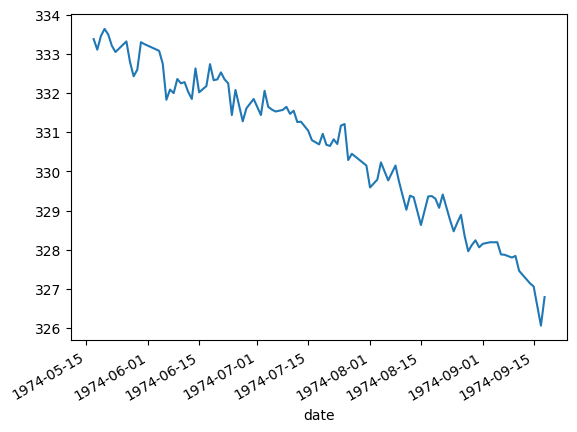

In [10]:
df["CO2 molfrac (ppm)"][:100].interpolate("linear").plot()

Interpolation uses a simple linear method to connect the dots for us 😊 Obviously this is making some assumptions that aren't perfectand we don't actually need to have daily samples - instead we'll `resample` our DataFrame on a monthly basis and try to model that. Try using the `.resample()` function to create a DataFrame with each month's average and name it `monthly`. See [docs](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html) here.

In [11]:
# Resample the data to get the monthly average CO2 values
monthly = df_full.resample('M').mean()

monthly.head()


/tmp/ipykernel_16116/2936825518.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df_full.resample('M').mean()


,CO2 molfrac (ppm)
1974-05-31,333.156923
1974-06-30,332.170400
1974-07-31,331.110000
1974-08-31,329.105769
1974-09-30,327.303182


If you __still__ have any remaining null values, you can use the `interpolate` to fill them in. Plot out your resampled data:

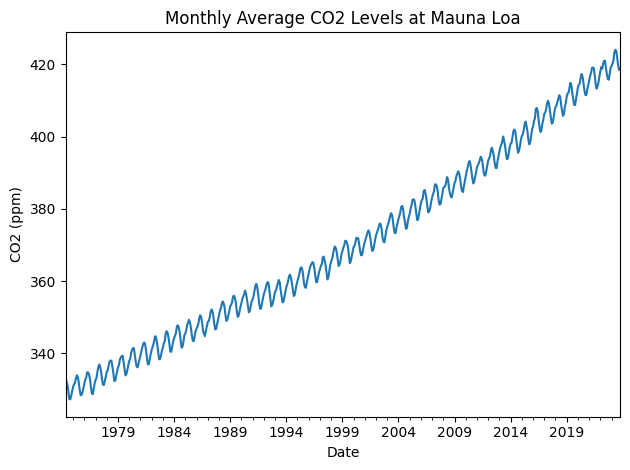

In [12]:
# Fill remaining null values using interpolation
monthly_interpolated = monthly.interpolate()

# Plot the resampled and interpolated monthly data
monthly_interpolated.plot(y='CO2 molfrac (ppm)', legend=False, title='Monthly Average CO2 Levels at Mauna Loa')
plt.ylabel('CO2 (ppm)')
plt.xlabel('Date')
plt.tight_layout()
plt.show()


<Axes: >

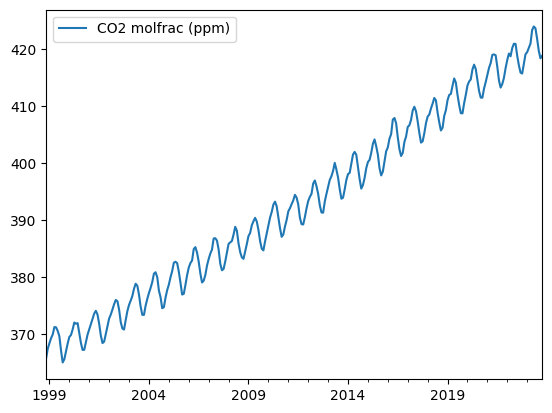

In [13]:
monthly[-300:].plot()

In [14]:
monthly["CO2 molfrac (ppm)"][0]

/tmp/ipykernel_16116/4232856447.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  monthly["CO2 molfrac (ppm)"][0]


333.1569230769231

In [15]:
from nbresult import ChallengeResult

result = ChallengeResult('monthly',
                         monthly = monthly)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/saranjthilak92/.pyenv/versions/3.12.9/envs/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /home/saranjthilak92/code/saranjthilak/05-ML/09-Time-Series/data-arima-101/tests
plugins: typeguard-4.4.2, anyio-4.8.0
collecting ... collected 2 items

test_monthly.py::TestMonthly::test_first_value PASSED                    [ 50%]
test_monthly.py::TestMonthly::test_missing PASSED                        [100%]

=============================== warnings summary ===============================
test_monthly.py::TestMonthly::test_first_value
  /home/saranjthilak92/code/saranjthilak/05-ML/09-Time-Series/data-arima-101/tests/test_monthly.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position

## Train test split

Next up we need to split into a train and test set (we'll do an 80:20 split). Be cautious when doing this - we need our sets to be __continuous__!

In [16]:
# Determine the index for 80% split
split_index = int(len(monthly_interpolated) * 0.8)

# Create train and test sets
train = monthly_interpolated.iloc[:split_index]
test = monthly_interpolated.iloc[split_index:]
tra

Our data preparation is almost done. Before we start decomposing and modelling though, we should come up with a baseline to see how our model performs. 

The typical baselines we'd pick is just to guess the last available value to us. In our case, this is simply the final point in our `train` DataFrame.

In your `test` DataFrame, create a column called `naive_preds` and set it to be equal to our last available data point in `train`


In [17]:
# Get the last value from the training set
last_train_value = train["CO2 molfrac (ppm)"].iloc[-1]

# Create a column of naive predictions in the test set
test["naive_preds"] = last_train_value
test

/tmp/ipykernel_16116/1157458204.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["naive_preds"] = last_train_value


,CO2 molfrac (ppm),naive_preds
2013-12-31,397.024000,395.360667
2014-01-31,398.043226,395.360667
2014-02-28,398.268889,395.360667
2014-03-31,399.895455,395.360667
2014-04-30,401.488889,395.360667
...,...,...
2023-06-30,423.675172,395.360667
2023-07-31,421.820952,395.360667
2023-08-31,419.720952,395.360667
2023-09-30,418.405556,395.360667


Once you have this, calculate the mean absolute error between the two columns and set this as your `baseline_mae`.

In [18]:
from sklearn.metrics import mean_absolute_error

# Calculate the mean absolute error between actual and naive predictions
baseline_mae = mean_absolute_error(test["CO2 molfrac (ppm)"], test["naive_preds"])

baseline_mae


14.503777783267303

In [19]:
from nbresult import ChallengeResult

result = ChallengeResult('baseline',
                         test = test,
                         baseline_mae = baseline_mae)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/saranjthilak92/.pyenv/versions/3.12.9/envs/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /home/saranjthilak92/code/saranjthilak/05-ML/09-Time-Series/data-arima-101/tests
plugins: typeguard-4.4.2, anyio-4.8.0
collecting ... collected 3 items

test_baseline.py::TestBaseline::test_baseline_mae PASSED                 [ 33%]
test_baseline.py::TestBaseline::test_first_value PASSED                  [ 66%]
test_baseline.py::TestBaseline::test_missing PASSED                      [100%]

=============================== warnings summary ===============================
test_baseline.py::TestBaseline::test_first_value
  /home/saranjthilak92/code/saranjthilak/05-ML/09-Time-Series/data-arima-101/tests/test_baseline.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be tr

## Getting ready to model

With some Time Series models, we can simply throw our data at it and hope that it will decompose it, make it stationary for us and then model it for us (SARIMAX or TBATS are good examples of this), but we're going to go step by step instead. Since we're not relying on a model to remove seasonality and trend for us, we will take care of them ourselves.

Import the `seasonal_decompose` tool that you saw in the lecture and try both methods on your Time Series (both "multiplicative" and "additive"). 

In [61]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform additive decomposition
additive_decomp = seasonal_decompose(monthly_interpolated["CO2 molfrac (ppm)"], model='additive')

# Perform multiplicative decomposition
multiplicative_decomp = seasonal_decompose(train, model='multiplicative')


TypeError: Index(...) must be called with a collection of some kind, 'seasonal' was passed

Plot the residuals (access the `.resid` attribute) from both and remember - we want the one that looks as __non-influenced__ by time as possible

In [ ]:
import matplotlib.pyplot as plt

# Plot residuals from additive decomposition
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
additive_decomp.resid.plot(title='Additive Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')

# Plot residuals from multiplicative decomposition
plt.subplot(1, 2, 2)
multiplicative_decomp.resid.plot(title='Multiplicative Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()


In [ ]:
train

Since both look reasonably stationary, we'll pick the multiplicative model.

Our strategy now is to take out the seasonal component of our time series. 

How can we do this? 🤔


First, create a column called `"seasonal_component"`in your `train` DataFrame that is filled with the `.seasonal` component of your time series. 

After you do this, create a separate, smaller DataFrame that only includes __one year__ of seasonal components (ie. the first 12 rows of your `seasonal components` column). This will be useful for us later on. Name it `seasonal_one_year` and make sure you have a `"month"` column equal to the corresponding `index.month` (e.g. you have have a row with the January seasonal component and a 1 next to it). 

<img src = "https://wagon-public-datasets.s3.amazonaws.com/data-science-images/05-ML/09-Time-Series/seasonal_component_one.png">

In [62]:
# Add the seasonal component to the train DataFrame
train['seasonal_component'] = multiplicative_decomp.seasonal.loc[train.index]

# Create a DataFrame with the first 12 months of seasonal components
seasonal_one_year = train['seasonal_component'].head(12).to_frame()

# Add a month column from the index
seasonal_one_year['month'] = seasonal_one_year.index.month


/tmp/ipykernel_16116/301811242.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['seasonal_component'] = multiplicative_decomp.seasonal.loc[train.index]


Since this is from a multiplicative model, if we want to __remove__ this seasonal component, we'll need to __divide__ our original time series by these repeating (12-month cycle) values.

In [63]:
from nbresult import ChallengeResult

result = ChallengeResult('seasonal',
                         train = train,
                         seasonal = seasonal_one_year)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/saranjthilak92/.pyenv/versions/3.12.9/envs/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /home/saranjthilak92/code/saranjthilak/05-ML/09-Time-Series/data-arima-101/tests
plugins: typeguard-4.4.2, anyio-4.8.0
collecting ... collected 2 items

test_seasonal.py::TestSeasonal::test_seasonal_column PASSED              [ 50%]
test_seasonal.py::TestSeasonal::test_seasonal_year_shape PASSED          [100%]

============================== 2 passed in 0.83s ===============================


💯 You can commit your code:

git add tests/seasonal.pickle

git commit -m 'Completed seasonal step'

git push origin master



Create a new column named `"seasonal_stripped"` equal to the value of your original time series divided by the seasonal component.

In [64]:
train['seasonal_stripped'] = train['CO2 molfrac (ppm)'] / train['seasonal_component']
train


/tmp/ipykernel_16116/2576728239.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['seasonal_stripped'] = train['CO2 molfrac (ppm)'] / train['seasonal_component']


,CO2 molfrac (ppm),seasonal_component,seasonal_stripped
1974-05-31,333.156923,1.008415,330.376951
1974-06-30,332.170400,1.006460,330.038270
1974-07-31,331.110000,1.001596,330.582324
1974-08-31,329.105769,0.995672,330.536193
1974-09-30,327.303182,0.991005,330.274095
...,...,...,...
2013-07-31,397.451905,1.001596,396.818502
2013-08-31,395.393704,0.995672,397.112241
2013-09-30,393.726538,0.991005,397.300373
2013-10-31,393.904286,0.990986,397.487162


Plot this new column out:

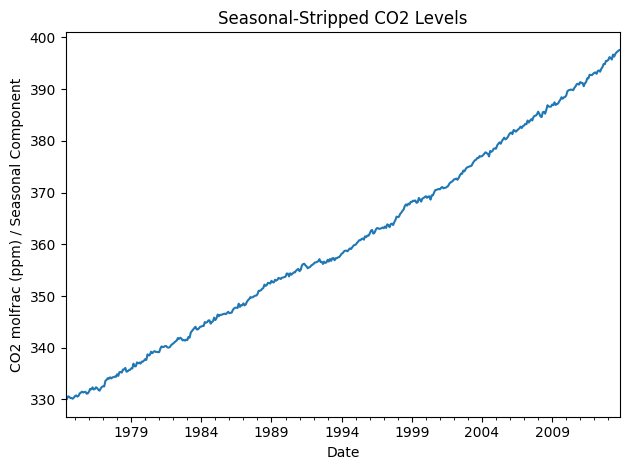

In [65]:
train['seasonal_stripped'].plot(title='Seasonal-Stripped CO2 Levels')
plt.xlabel('Date')
plt.ylabel('CO2 molfrac (ppm) / Seasonal Component')
plt.tight_layout()
plt.show()


Does it look stationary yet? Discuss with your buddy for the day why or why not.

Our next task is to take this __deseasonalized__ time series and to make it stationary. Try using `.diff()` and see how it looks. Then try diffing one more time to see any changes. 

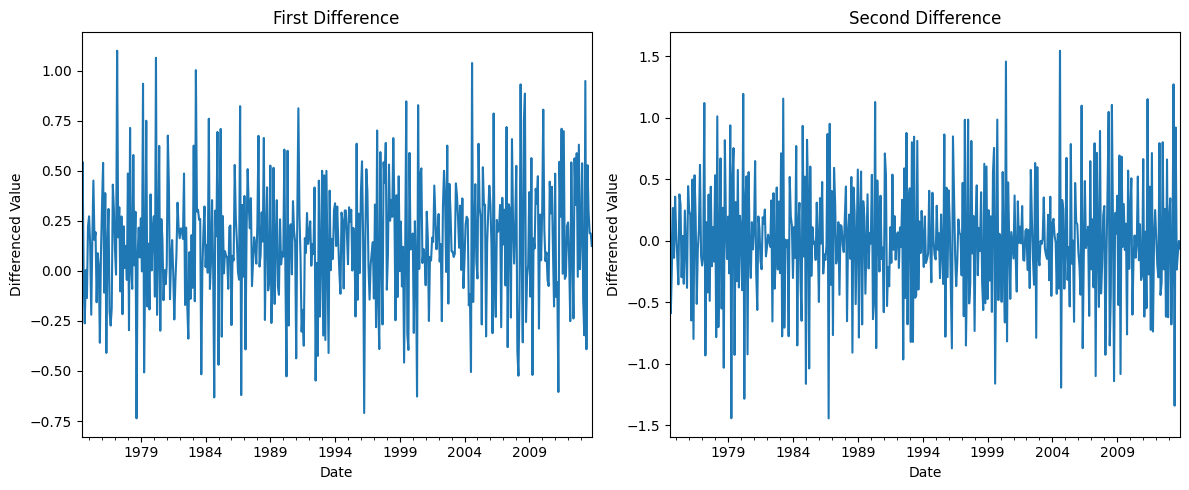

In [66]:
# First difference to remove trend
diff_1 = train['seasonal_stripped'].diff().dropna()

# Second difference to remove any remaining trend or seasonality
diff_2 = diff_1.diff().dropna()

# Plot both differenced series side by side
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
diff_1.plot(title='First Difference')
plt.xlabel('Date')
plt.ylabel('Differenced Value')

plt.subplot(1, 2, 2)
diff_2.plot(title='Second Difference')
plt.xlabel('Date')
plt.ylabel('Differenced Value')

plt.tight_layout()
plt.show()


Both should look quite stationary visually, use the `adfuller` (Augmented Dicky-Fuller) test from the lecture to verify that each one is. 

N.B. When you `diff` you create null values in your DataFrame, you'll need to drop these to perform an ADF test.

In [67]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test on first difference (drop nulls)
adf_result_1 = adfuller(diff_1.dropna())
print(f"ADF Statistic (1st diff): {adf_result_1[0]}")
print(f"p-value (1st diff): {adf_result_1[1]}")

# Perform ADF test on second difference (drop nulls)
adf_result_2 = adfuller(diff_2.dropna())
print(f"ADF Statistic (2nd diff): {adf_result_2[0]}")
print(f"p-value (2nd diff): {adf_result_2[1]}")


ADF Statistic (1st diff): -5.355361534312634
p-value (1st diff): 4.200606315487704e-06
ADF Statistic (2nd diff): -12.696437145512663
p-value (2nd diff): 1.1035122656386295e-23


Both seem to be reasonably stationary, and it looks like there's no need to overdifference (though we can always try building a twice-diffed time series later). Let's go ahead and plot our `acf` and `pacf` plots (be sure to drop any `null` values - those will break your ACF and PACF calculators) 😔

In [68]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

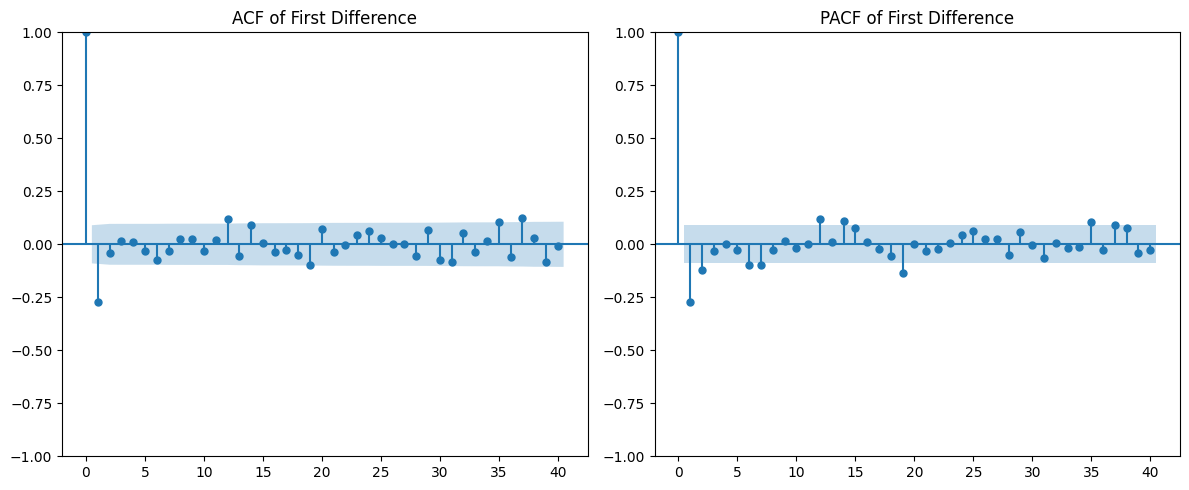

In [69]:
# Drop null values from first differenced series
diff_1_clean = diff_1.dropna()

# Plot ACF and PACF
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plot_acf(diff_1_clean, lags=40, ax=plt.gca(), title='ACF of First Difference')

plt.subplot(1, 2, 2)
plot_pacf(diff_1_clean, lags=40, ax=plt.gca(), title='PACF of First Difference')

plt.tight_layout()
plt.show()


In [70]:
train

,CO2 molfrac (ppm),seasonal_component,seasonal_stripped
1974-05-31,333.156923,1.008415,330.376951
1974-06-30,332.170400,1.006460,330.038270
1974-07-31,331.110000,1.001596,330.582324
1974-08-31,329.105769,0.995672,330.536193
1974-09-30,327.303182,0.991005,330.274095
...,...,...,...
2013-07-31,397.451905,1.001596,396.818502
2013-08-31,395.393704,0.995672,397.112241
2013-09-30,393.726538,0.991005,397.300373
2013-10-31,393.904286,0.990986,397.487162


Take the time to really talk through what these plots actually mean with your buddy. Which one corresponds to your `p` parameter and which corresponds to your `q` parameter?

Now build a simple ARIMA model with the appropriate order values for your `p` `d` and `q` values. Investigate its model summary.

In [75]:
from statsmodels.tsa.arima.model import ARIMA

# Based on the differencing, d=1; select p and q from ACF/PACF plots (example p=1, q=1)
model = ARIMA(train['seasonal_stripped'], order=(2, 1, 1))
arima_result = model.fit()

# Print the model summary
print(arima_result.summary())


/home/saranjthilak92/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/saranjthilak92/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:      seasonal_stripped   No. Observations:                  475
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -111.020
Date:                Thu, 15 May 2025   AIC                            230.039
Time:                        16:44:59   BIC                            246.684
Sample:                    05-31-1974   HQIC                           236.585
                         - 11-30-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7256      0.044     16.364      0.000       0.639       0.813
ar.L2          0.2743      0.044      6.184      0.000       0.187       0.361
ma.L1         -0.9924      0.011    -93.243      0.0

What do you note about the summary? What are the most important features here?

It looks like we can trust our coefficients and we have an AIC of ~223. But was it the best model? Trying using the `auto_arima` function to grid search different models and see which has the best AIC

In [76]:
from pmdarima import auto_arima

# Use auto_arima to find the best model order based on AIC
auto_model = auto_arima(train['seasonal_stripped'], seasonal=True, stepwise=True, trace=True, suppress_warnings=True, test = "adf", )

# Print the best model summary
print(auto_model.summary())


/home/saranjthilak92/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/saranjthilak92/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/saranjthilak92/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/saranjthilak92/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/saranjthilak92/.pyenv/versions

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=219.660, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=257.276, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=222.996, Time=0.09 sec


/home/saranjthilak92/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/saranjthilak92/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/saranjthilak92/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=215.963, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=342.245, Time=0.05 sec


/home/saranjthilak92/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/saranjthilak92/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=217.104, Time=0.15 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=217.192, Time=0.19 sec


/home/saranjthilak92/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/saranjthilak92/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=217.672, Time=0.63 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=343.039, Time=0.05 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 2.264 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  475
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -104.981
Date:                Thu, 15 May 2025   AIC                            215.963
Time:                        16:45:04   BIC                            228.446
Sample:                    05-31-1974   HQIC                           220.872
                         - 11-30-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
int

/home/saranjthilak92/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Save your best AIC score to `best_AIC`

In [77]:
best_AIC = auto_model.aic()
best_AIC


215.9626761931162

In [74]:
from nbresult import ChallengeResult

result = ChallengeResult('score',
                         aic_score = best_AIC)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/saranjthilak92/.pyenv/versions/3.12.9/envs/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /home/saranjthilak92/code/saranjthilak/05-ML/09-Time-Series/data-arima-101/tests
plugins: typeguard-4.4.2, anyio-4.8.0
collecting ... collected 1 item

test_score.py::TestScore::test_AIC_score FAILED                          [100%]

=================================== FAILURES ===================================
___________________________ TestScore.test_AIC_score ___________________________

self = <test_score.TestScore testMethod=test_AIC_score>

    def test_AIC_score(self):
>       self.assertTrue(self.result.aic_score < 210.0)
E       AssertionError: False is not true

test_score.py:5: AssertionError
=========================== short test summary info ============================
FAILED test_score.py::TestScore::test_AIC_score - AssertionE

Often times, it can be hard to predict which model with fit best on our data so it is usually a good idea to grid-search and compare your models' AIC scores 🧐 Here, it looks like a __(0,1,1)__ model gets a better AIC score (so the MA components of our original model probably weren't improving our model likelihood that much!)

### Making predictions (get ready for some Pandas work!)

Now that we have our best model, we'd like to generate some predictions and - crucially - some confidence intervals. Use your model to predict for the length of your test set and ensure that you also return those intervals (use `return_conf_int = True`). Create a `preds_df` DataFrame with columns for `preds`, `upper` and `lower` bounds.

In [35]:
# Generate predictions for the length of the test set with confidence intervals
n_periods = len(test)
preds, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)

# Create DataFrame with predictions and confidence intervals
preds_df = pd.DataFrame({
    "preds": preds,
    "lower": conf_int[:, 0],
    "upper": conf_int[:, 1]
}, index=test.index)

preds_df.head()


/home/saranjthilak92/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/saranjthilak92/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,preds,lower,upper
2013-12-31,397.774236,397.184854,398.363619
2014-01-31,397.938232,397.223769,398.652696
2014-02-28,398.107301,397.295522,398.919081
2014-03-31,398.278940,397.392442,399.165438
2014-04-30,398.452426,397.502378,399.402473


In [36]:
# YOUR CODE HERE

In [37]:
# YOUR CODE HERE

In [38]:
from nbresult import ChallengeResult

result = ChallengeResult('preds',
                         preds_df = preds_df)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/saranjthilak92/.pyenv/versions/3.12.9/envs/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /home/saranjthilak92/code/saranjthilak/05-ML/09-Time-Series/data-arima-101/tests
plugins: typeguard-4.4.2, anyio-4.8.0
collecting ... collected 2 items

test_preds.py::TestPreds::test_df_values PASSED                          [ 50%]
test_preds.py::TestPreds::test_preds_cols PASSED                         [100%]

=============================== warnings summary ===============================
test_preds.py::TestPreds::test_df_values
  /home/saranjthilak92/code/saranjthilak/05-ML/09-Time-Series/data-arima-101/tests/test_preds.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `

Now plot them, out and see how they look compared alongside your `train` data

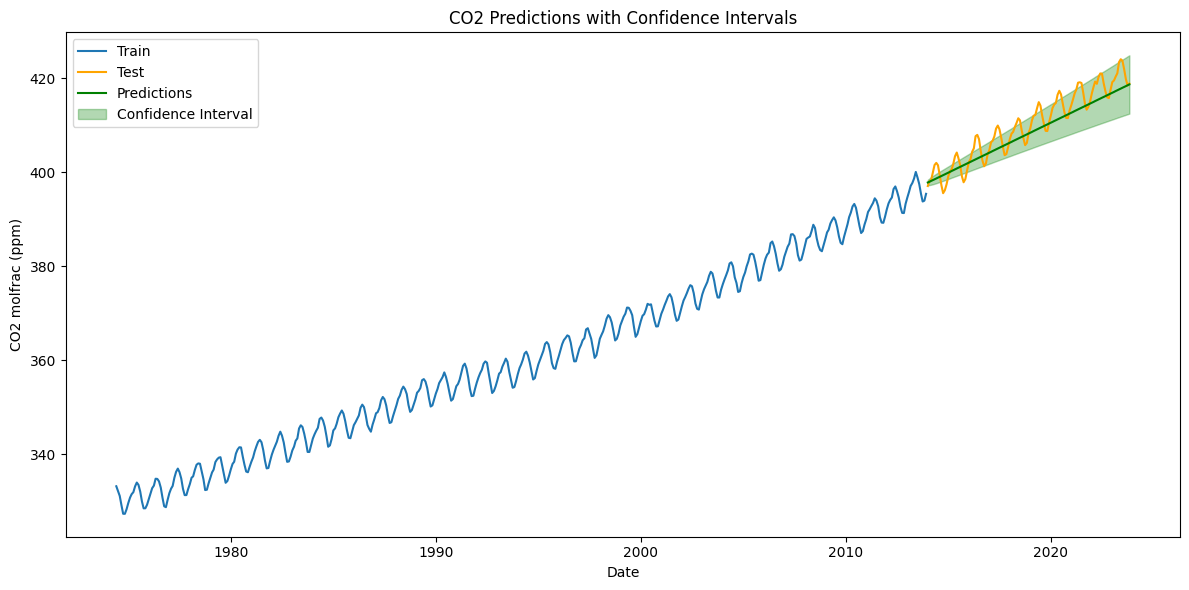

In [39]:
# Plot the original train and test data
plt.figure(figsize=(12, 6))
plt.plot(train.index, train["CO2 molfrac (ppm)"], label="Train")
plt.plot(test.index, test["CO2 molfrac (ppm)"], label="Test", color='orange')

# Plot predictions
plt.plot(preds_df.index, preds_df["preds"], label="Predictions", color='green')

# Plot confidence intervals
plt.fill_between(preds_df.index, preds_df["lower"], preds_df["upper"], color='green', alpha=0.3, label="Confidence Interval")

plt.title("CO2 Predictions with Confidence Intervals")
plt.xlabel("Date")
plt.ylabel("CO2 molfrac (ppm)")
plt.legend()
plt.tight_layout()
plt.show()


Something looks a bit wrong doesn't it? We're looking at three straight lines coming out of something that clearly had seasonality. To account for this, we need to re-incorporate the seasonality component that we extracted earlier!

Create a `month` column in your `preds_df` DataFrame and populate it with the month component of the index. 

In [40]:
# Add a 'month' column from the index
preds_df['month'] = preds_df.index.month


Now we can take our `seasonal_one_year` DataFrame that we made earlier and simply merge it onto our `preds_df`!

In [41]:
# Merge preds_df with seasonal_one_year on 'month'
preds_df = preds_df.merge(seasonal_one_year, on='month', how='left')


In [42]:
preds_df

,preds,lower,upper,month,seasonal_component
0,397.774236,397.184854,398.363619,12,0.997714
1,397.938232,397.223769,398.652696,1,1.000345
2,398.107301,397.295522,398.919081,2,1.002096
3,398.278940,397.392442,399.165438,3,1.004083
4,398.452426,397.502378,399.402473,4,1.007287
...,...,...,...,...,...
114,417.922252,411.923982,423.920521,6,1.006460
115,418.099314,412.049143,424.149485,7,1.001596
116,418.276377,412.174175,424.378579,8,0.995672
117,418.453439,412.299076,424.607803,9,0.991005


Now you can create your `full_preds`, `upper_conf` and `lower_conf` (create them as new columns in the `preds_df` DataFrame) by multiplying out your `preds`, `upper` __and__ `lower` columns with the seasonal component that we now have in our `preds_df` DataFrame.

In [43]:
# Multiply predictions and confidence intervals by the seasonal component
preds_df['full_preds'] = preds_df['preds'] * preds_df['seasonal_component']
preds_df['upper_conf'] = preds_df['upper'] * preds_df['seasonal_component']
preds_df['lower_conf'] = preds_df['lower'] * preds_df['seasonal_component']
preds_df

,preds,lower,upper,month,seasonal_component,full_preds,upper_conf,lower_conf
0,397.774236,397.184854,398.363619,12,0.997714,396.864817,397.452852,396.276782
1,397.938232,397.223769,398.652696,1,1.000345,398.075565,398.790275,397.360855
2,398.107301,397.295522,398.919081,2,1.002096,398.941768,399.755249,398.128287
3,398.278940,397.392442,399.165438,3,1.004083,399.905294,400.795412,399.015176
4,398.452426,397.502378,399.402473,4,1.007287,401.356091,402.313061,400.399120
...,...,...,...,...,...,...,...,...
114,417.922252,411.923982,423.920521,6,1.006460,420.622134,426.659154,414.585114
115,418.099314,412.049143,424.149485,7,1.001596,418.766685,424.826514,412.706857
116,418.276377,412.174175,424.378579,8,0.995672,416.466250,422.542044,410.390456
117,418.453439,412.299076,424.607803,9,0.991005,414.689327,420.788330,408.590324


Finally, to make plotting easier for us, set the index of your `preds_df` to be the same as the index of your `test` DataFrame (since they have the same length this should be quite easy for us!)

In [44]:
# Set the index of preds_df to match the test DataFrame
preds_df.index = test.index


In [45]:
from nbresult import ChallengeResult

result = ChallengeResult('fullpreds',
                         preds_df = preds_df)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/saranjthilak92/.pyenv/versions/3.12.9/envs/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /home/saranjthilak92/code/saranjthilak/05-ML/09-Time-Series/data-arima-101/tests
plugins: typeguard-4.4.2, anyio-4.8.0
collecting ... collected 2 items

test_fullpreds.py::TestFullpreds::test_columns PASSED                    [ 50%]
test_fullpreds.py::TestFullpreds::test_index PASSED                      [100%]

============================== 2 passed in 0.63s ===============================


💯 You can commit your code:

git add tests/fullpreds.pickle

git commit -m 'Completed fullpreds step'

git push origin master



Now plot everything out - the end of your train (e.g. the last 100 values, your full predictions, upper and lower confidence bounds and the true values from your `preds_df` DataFrame __and__ your baseline!

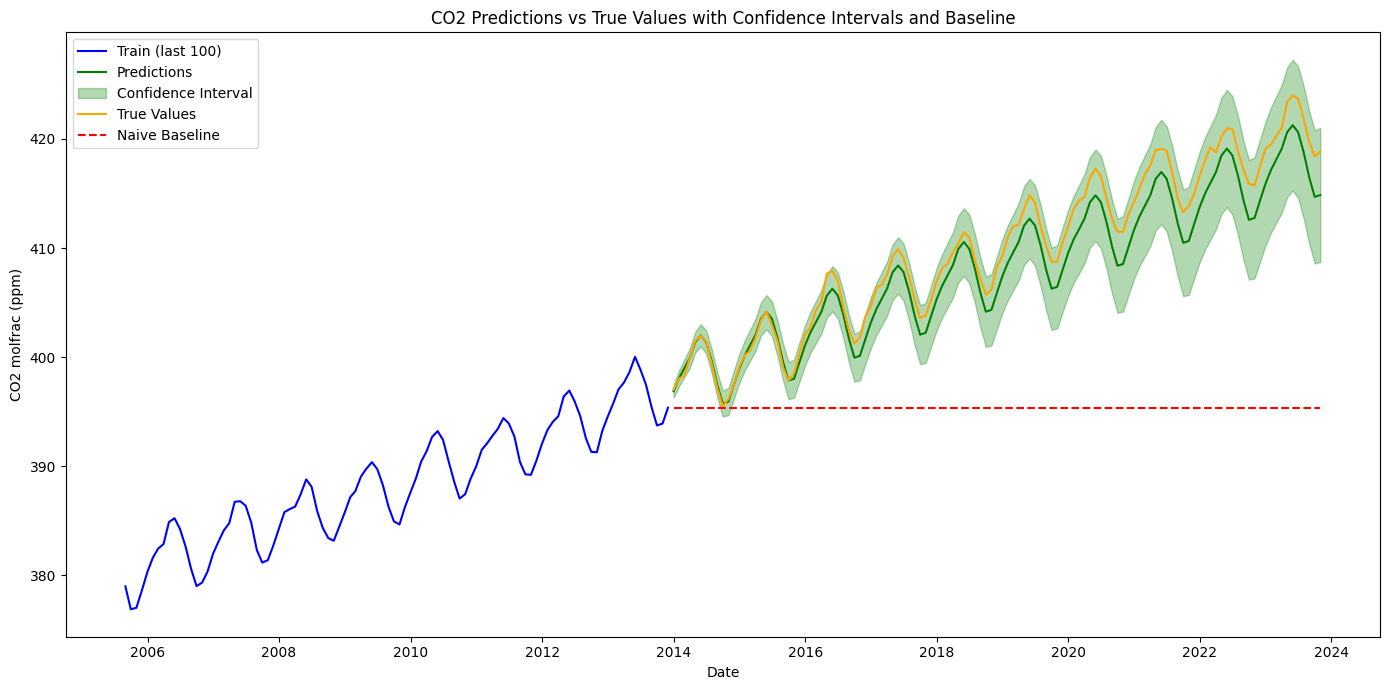

In [46]:
plt.figure(figsize=(14, 7))

# Plot the last 100 points of the train data
plt.plot(train.index[-100:], train['CO2 molfrac (ppm)'][-100:], label='Train (last 100)', color='blue')

# Plot full predictions
plt.plot(preds_df.index, preds_df['full_preds'], label='Predictions', color='green')

# Plot confidence intervals
plt.fill_between(preds_df.index, preds_df['lower_conf'], preds_df['upper_conf'], color='green', alpha=0.3, label='Confidence Interval')

# Plot true values
plt.plot(test.index, test['CO2 molfrac (ppm)'], label='True Values', color='orange')

# Plot baseline naive predictions
plt.plot(test.index, test['naive_preds'], label='Naive Baseline', color='red', linestyle='--')

plt.title('CO2 Predictions vs True Values with Confidence Intervals and Baseline')
plt.xlabel('Date')
plt.ylabel('CO2 molfrac (ppm)')
plt.legend()
plt.tight_layout()
plt.show()


Our predictions look pretty good! We can see that the true values are slightly higher than what we predicted but remains well within the bounds of our confidence intervals for a full 10 years out from when we started making our predictions.

Why did our values dip below the true values? Run the cell below to decompose the test data and take a look at the trend component 👀


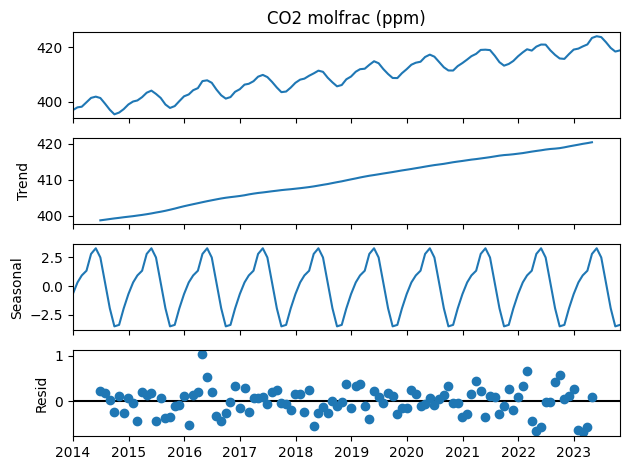

In [47]:
seasonal_decompose(test["CO2 molfrac (ppm)"]).plot();

It looks like in 2016-2018 there was a __slight rise__ in all of our values before the regular (slightly shallower) trend took over again. This is a great example of something occuring in our test dataset that we simply cannot predict. We don't know why there was a surge in CO2 readings - and we couldn't predict for it.

❗ When we model with Time Series, we __cannot magically predict the future__. What we're trying to do is accurately capture and then extend the patterns of the past. 

- Often times, your raw predictions (without a seasonal component) will look like a fairly boring straight line 🙄 (as our current initial ones did) but this is what we'd expect
- Some of the most value that we get out when doing Time Series analysis lies in being able to __quantify__ our trends, seasonal components and our confidence intervals so we can make well-informed decisions ✅

Finally, let's quickly quantify how much better our model was than our baseline. Calculate the mean absolute error between your `preds` (with their seasonal component) and the true values. See if your `model_mae` is lower than the original `baseline_mae`. 

In [48]:
model_mae = (test["CO2 molfrac (ppm)"] - preds_df["full_preds"]).mean()

In [49]:
from sklearn.metrics import mean_absolute_error

# Calculate MAE for the model predictions with seasonal component
model_mae = mean_absolute_error(test['CO2 molfrac (ppm)'], preds_df['full_preds'])

# Check if model MAE is lower than baseline MAE
print(f"Baseline MAE: {baseline_mae}")
print(f"Model MAE: {model_mae}")
print("Model performs better than baseline:", model_mae < baseline_mae)


Baseline MAE: 14.503777783267303
Model MAE: 1.7247385085501672
Model performs better than baseline: True


Our final MAE should be __much__ better than our original baseline. Great work 🥳 In another challenge, we'll explore how we can use Facebook Prophet to quickly make powerful predictions without the need for decomposition.